In [256]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [257]:
n = 2 #number of pipes
if not isinstance(n, int):
    raise ValueError("Number of pipes 'n' must be an integer.")
Q = 93.19 # Q_50 in m3/s
Q_i = Q / n #flow per pipe in m3/s
h_0 = 74 #m
h_end = 175 #m
l_surge = 8300 #length of penstock until surge tank m
l_total = 9300 #total length of penstock m

D_req = np.sqrt((4*Q_i)/(np.pi*V_pipe))

print(f"Required diameter of penstock: {D_req:.2f} m")

Required diameter of penstock: 4.40 m


In [258]:
def penstock_head_loss(D, Q_i, l_total, n):
    xi_ent = 0.1
    xi_ex = 1.0
    xi_bend = 0.5

    Q = Q_i / n # total flow in m3/s
    v = Q / ((np.pi/4) * D**2) # velocity in pipe in m/s

    h_f = 0.015 * (l_total/D) * (v**2/(2*9.81)) # head loss in m

    h_f_ent = xi_ent * ((v**2)/(2*9.81)) # head loss at entrance in m
    h_f_ex = xi_ex * ((v**2)/(2*9.81)) # head loss at exit in m
    h_f_bend = xi_bend * ((v**2)/(2*9.81)) # head loss at bend in m

    h_total_loss = h_f + h_f_ent + (2 * h_f_ex) + (2 * h_f_bend)

    return h_total_loss

def penstock_costs(D, l_total, n):
    cost_per_kg = 1  # EUR/kg
    steel_density = 7850  # kg/m^3
    outer_radius = D / 2
    t_min = D/288
    inner_radius = outer_radius - t_min
    
    # Volume of tube wall
    volume_m3 = np.pi * l_total * (outer_radius**2 - inner_radius**2) * n

    # Mass of steel
    mass_kg = volume_m3 * steel_density
    
    # Total cost
    cost_eur = (mass_kg * cost_per_kg / 10**6)
    
    return cost_eur

def head_loss_cost(Q, h_f):
    hours_per_year=24*365*0.8
    electricity_price_eur_per_kwh=0.20
    eta = 0.85
    rho = 1000  # kg/m³
    g = 9.81    # m/s²

    # Power lost due to 1 meter head loss (in watts)
    power_watts = rho * g * Q * eta * h_f

    # Convert to kWh/year
    energy_kwh = (power_watts / 1000) * hours_per_year * 50

    # Cost
    cost_eur = energy_kwh * electricity_price_eur_per_kwh / 10**8

    return cost_eur

# Example usage
cost = head_loss_cost(Q=2.0, h_f=1.0)

print(f"Estimated annual cost of 1 meter head loss: €{cost}")

Estimated annual cost of 1 meter head loss: €0.011687241599999999


for n=1, required minimum diameter 4.45 m exceeds maximum considered diameter 3.3 m. Skipping.
Minimum total cost for  n=2 at D=3.30 m: €54.66 million
total penstock cost for n=2 at D=3.30 m: €17.28 million
total headloss cost for n=2 at D=3.30 m: €37.38 million

Minimum total cost for  n=3 at D=3.30 m: €42.54 million
total penstock cost for n=3 at D=3.30 m: €25.93 million
total headloss cost for n=3 at D=3.30 m: €16.61 million

Minimum total cost for  n=4 at D=3.12 m: €43.22 million
total penstock cost for n=4 at D=3.12 m: €30.80 million
total headloss cost for n=4 at D=3.12 m: €12.42 million



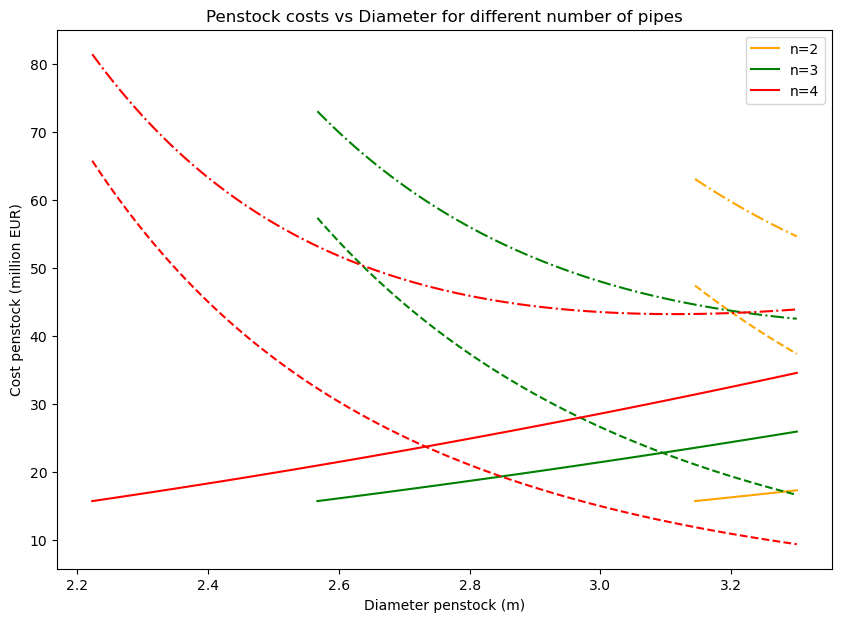

In [259]:


fig, ax = plt.subplots(figsize=(10,7))
colors = ['blue', 'orange', 'green', 'red']
for i, n in enumerate([1, 2, 3, 4]):
    D_min = np.sqrt((4*Q/n)/(np.pi*6))
    D_max = 3.3
    if D_min > D_max:
        print(f"for n={n}, required minimum diameter {D_min:.2f} m exceeds maximum considered diameter {D_max} m. Skipping.")
    else:  
        D = np.linspace(D_min, D_max, 100)  
        h_losses = penstock_head_loss(D, Q, l_total, n)
        # ax.plot(D, h_losses, color = "red", label=f'Head loss (m), n={n}')
        head_loss_costs_tot = head_loss_cost(Q, h_losses)

        penstock_costs_tot = penstock_costs(D, l_total, n)

        total = head_loss_costs_tot + penstock_costs_tot

        ax.plot(D, penstock_costs_tot, linestyle='-', label=f'n={n}', color=colors[i])
        ax.plot(D, head_loss_costs_tot, linestyle='--', color=colors[i])
        ax.plot(D, total, linestyle='-.', color=colors[i])

        C_min_index = np.argmin(total)
        C_min = total[C_min_index]
        D_min = D[C_min_index]
        print(f"Minimum total cost for  n={n} at D={D_min:.2f} m: €{C_min:.2f} million")
        print(f"total penstock cost for n={n} at D={D_min:.2f} m: €{penstock_costs_tot[C_min_index]:.2f} million")
        print(f"total headloss cost for n={n} at D={D_min:.2f} m: €{head_loss_costs_tot[C_min_index]:.2f} million")
        print()

        ax.set_ylabel('Cost penstock (million EUR)')
        ax.set_xlabel('Diameter penstock (m)')
        ax.set_title('Penstock costs vs Diameter for different number of pipes')
        ax.legend()
        # ax.grid()
    plt.savefig("..\\figures\\penstock_costs_vs_diameter_multiple_pipes.png", dpi=300)


final diameter penstock: 3.11 m
minimal thickness penstock: 0.010 m
velocity in penstock: 3.06 m/s


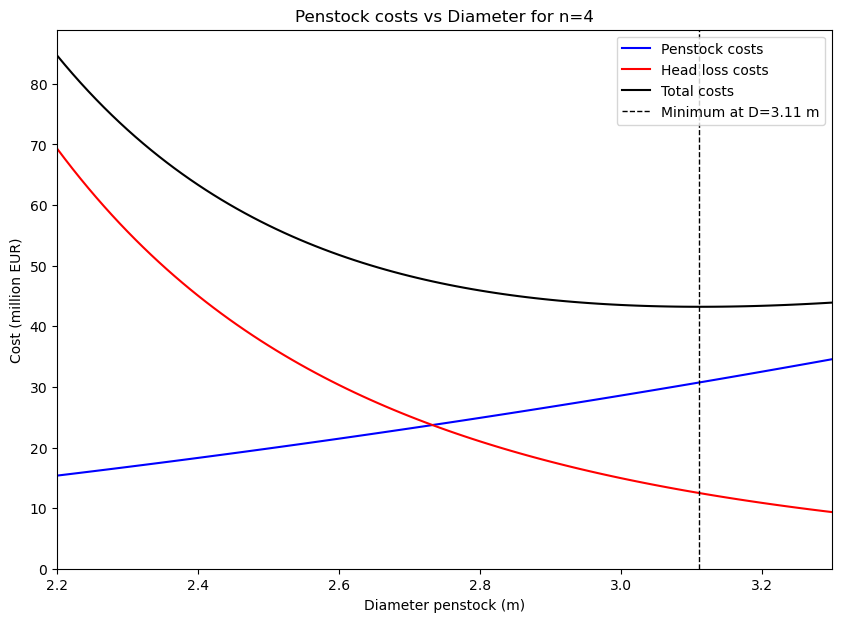

In [260]:
n = 4
D = np.linspace(2.2, 3.3, 100)
fig, ax = plt.subplots(figsize=(10,7))
penstock_costs_tot = penstock_costs(D, l_total, n)
head_losses = penstock_head_loss(D, Q, l_total, n)
head_loss_costs_tot = head_loss_cost(Q, head_losses)
total = penstock_costs_tot + head_loss_costs_tot

C_min_index = np.argmin(total)
C_min = total[C_min_index]
D_min = D[C_min_index]
V_pipe = Q/n/(np.pi * (D_min/2)**2)

ax.plot(D, penstock_costs_tot, linestyle='-', label='Penstock costs', color='blue')
ax.plot(D, head_loss_costs_tot, linestyle='-', label='Head loss costs', color='red')
ax.plot(D, total, linestyle='-', label='Total costs', color='black')
ax.vlines(D_min,0, total.max()*1.05, color='black', linestyle='--', label=f'Minimum at D={D_min:.2f} m', lw = 1)

# ax.grid()
ax.set_ylabel('Cost (million EUR)')
ax.set_xlabel('Diameter penstock (m)')
ax.set_title('Penstock costs vs Diameter for n=4')
ax.legend()
ax.set_xlim(D.min(), D.max())
ax.set_ylim(0, total.max()*1.05)

print(f"final diameter penstock: {D_min:.2f} m")
print(f"minimal thickness penstock: {(D_min/400) + 0.002:.3f} m")
print(f"velocity in penstock: {V_pipe:.2f} m/s")

plt.savefig("..\\figures\\penstock_costs_vs_diameter_n4.png", dpi=300)



In [261]:
elev_0 = 501
elev_s = 450
elev_p = 400

f = 0.015 #Darcy-Weisbach friction factor
D = 3.15

E = 210 * 10**6
nu = 0.3

head_0 = elev_0 + h_0
h_f = f * (V_pipe**2/(2*9.81*D)) # head loss along pipe in m/m

elev_penstock = np.zeros(10000)
x = np.linspace(0, l_total, 10000)
x_bend1 = 5300
x_bend2 = 8750
elev_penstock[np.where(x <= l_surge)] = np.linspace(elev_0, elev_s, np.sum(x <= l_surge))
elev_penstock[np.where((x > l_surge) & (x <= x_bend2))] = np.linspace(elev_s, elev_p, np.sum((x > l_surge) & (x <= x_bend2)))
elev_penstock[np.where(x > x_bend2)] = elev_p

xi_ent = 0.1
xi_ex = 1.0
xi_bend = 0.5

h_f_ent = xi_ent * ((V_pipe**2)/(2*9.81)) # head loss at entrance in m
h_f_ex = xi_ex * ((V_pipe**2)/(2*9.81)) # head loss at exit in m
h_f_bend = xi_bend * ((V_pipe**2)/(2*9.81)) # head loss at bend in m

head_f = head_0 - (h_f * x)
head_f[np.where(x > x_bend1)] -= h_f_bend
head_f[np.where(x > l_surge)] -= (h_f_ex + h_f_ent)
head_f[np.where(x > x_bend2)] -= h_f_bend
head_f[-1] = head_f[-1]  - h_f_ex

print(f"total head_loss : {head_0 - head_f[-1]}")

h_f_total = (h_f * l_total) + (2*h_f_bend) + h_f_ent + (h_f_ex * 2)

p = (head_f - elev_penstock) * 9.8

tmin = ((p * (1-nu)) / (2 * E))**(1/3)

tdes = np.zeros(len(x))
tdes[np.where(x <= 2000)] = tmin[np.where(x < 2000)].max()
tdes[np.where((x > 2000) & (x <= 4000))] = tmin[np.where((x > 2000) & (x <= 4000))].max()
tdes[np.where((x > 4000) & (x <= x_bend1))] = tmin[np.where((x > 4000) & (x <= x_bend1))].max()
tdes[np.where((x > x_bend1) & (x <= 7000))] = tmin[np.where((x > x_bend1) & (x <= 7000))].max()
tdes[np.where((x > 7000) & (x <= l_surge))] = tmin[np.where((x > 7000) & (x <= l_surge))].max()
tdes[np.where((x > l_surge) & (x <= x_bend2))] = tmin[np.where((x > l_surge) & (x <= x_bend2))].max()
tdes[np.where((x > x_bend2))] = tmin[np.where((x > x_bend2))].max()

t_list = np.unique(np.round(tdes, 4))


print(f"bending losses: {2*h_f_bend:.2f} m")
print(f"entrance losses: {h_f_ent:.2f} m")
print(f"exit losses: {h_f_ex:.2f} m")

total head_loss : 22.684291471970482
bending losses: 0.48 m
entrance losses: 0.05 m
exit losses: 0.48 m


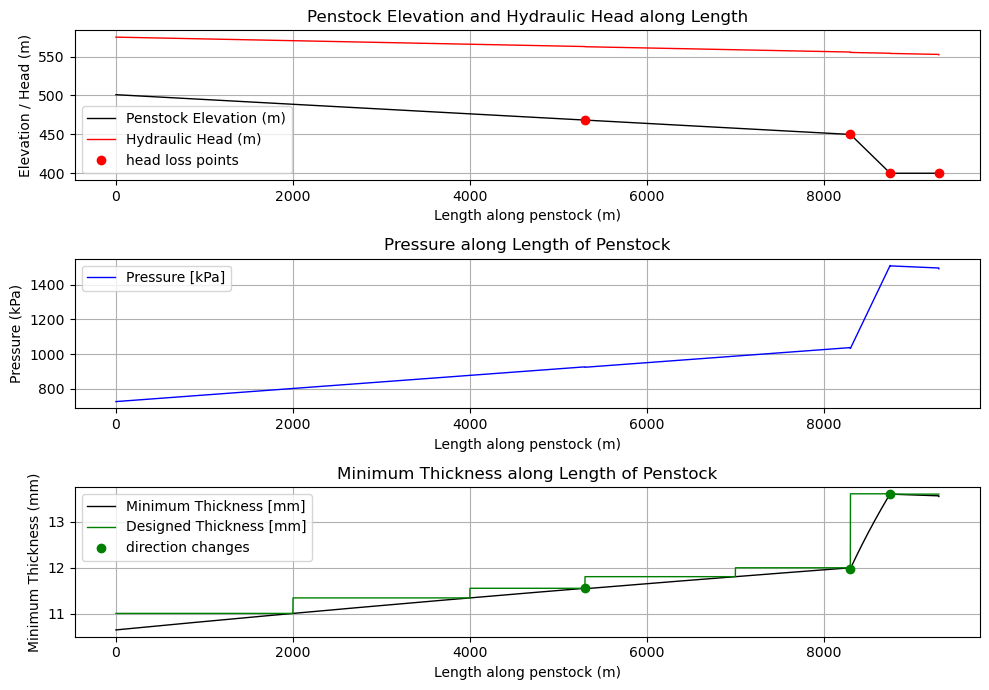

In [262]:
fig, axes = plt.subplots(3, figsize=(10, 7), layout='tight')
axes[0].plot(x, elev_penstock, label='Penstock Elevation (m)', color='black', lw=1)
axes[0].plot(x, head_f, label='Hydraulic Head (m)', color='red', lw = 1)
axes[0].set_xlabel('Length along penstock (m)')
axes[0].set_ylabel('Elevation / Head (m)')
axes[0].set_title('Penstock Elevation and Hydraulic Head along Length')

axes[0].plot(x_bend1, elev_penstock[np.argmin(np.abs(x - x_bend1))], 'o', color='red', label='head loss points')
axes[0].plot(x_bend2, elev_penstock[np.argmin(np.abs(x - x_bend2))], 'o', color='red')
axes[0].plot(l_surge, elev_penstock[np.argmin(np.abs(x - l_surge))], 'o', color='red')
axes[0].plot(l_total, elev_penstock[-1], 'o', color='red')

axes[0].legend()
axes[0].grid()

axes[1].plot(x, p, label='Pressure [kPa]', color='blue', lw=1)
axes[1].set_xlabel('Length along penstock (m)')
axes[1].set_ylabel('Pressure (kPa)')
axes[1].set_title('Pressure along Length of Penstock')
axes[1].legend()
axes[1].grid()

axes[2].plot(x, tmin*1000, label='Minimum Thickness [mm]', color='black', linestyle='-', lw=1)
axes[2].plot(x, tdes*1000, label='Designed Thickness [mm]', color='green', linestyle='-', lw=1)
axes[2].set_xlabel('Length along penstock (m)')
axes[2].set_ylabel('Minimum Thickness (mm)')
axes[2].set_title('Minimum Thickness along Length of Penstock')
axes[2].legend()
axes[2].grid()

axes[2].plot(x_bend1, tmin[np.argmin(np.abs(x - x_bend1))]*1000, 'o', color='green', label='direction changes')
axes[2].plot(x_bend2, tmin[np.argmin(np.abs(x - x_bend2))]*1000, 'o', color='green')
axes[2].plot(l_surge, tmin[np.argmin(np.abs(x - l_surge))]*1000, 'o', color='green')

axes[2].legend()

plt.savefig('..\\figures\\Penstock_Design.png', dpi=300)

In [263]:
for i, t in enumerate(t_list):
    count = np.sum(np.isclose(tdes, t, atol=1e-4))
    print(f"Thickness t{i+1} {t*1000:.2f} mm occurs over {count} m of penstock length.")

df = pd.DataFrame({'thickness (mm)': t_list*1000})

df['start length (m)'] = [0, 2000, 4000, x_bend1, 7000, l_surge]
df['end length (m)'] = [2000, 4000, x_bend1, 7000, l_surge, l_total]
df['segment length (m)'] = df['end length (m)'] - df['start length (m)']

df['inner diameter (m)'] = np.round(D_min, 2)
df['outer diameter (m)'] = df['inner diameter (m)'] + np.round(df['thickness (mm)']/1000, 4)
display(df)

latex_table = df.to_latex(index=False, caption='Hydropower Parameters', label='tab:hydro_params')
print(latex_table)


Thickness t1 11.00 mm occurs over 2151 m of penstock length.
Thickness t2 11.30 mm occurs over 2150 m of penstock length.
Thickness t3 11.60 mm occurs over 1398 m of penstock length.
Thickness t4 11.80 mm occurs over 1828 m of penstock length.
Thickness t5 12.00 mm occurs over 1397 m of penstock length.
Thickness t6 13.60 mm occurs over 1076 m of penstock length.


,thickness (mm),start length (m),end length (m),segment length (m),inner diameter (m),outer diameter (m)
0,11.0,0,2000,2000,3.11,3.1210
1,11.3,2000,4000,2000,3.11,3.1213
2,11.6,4000,5300,1300,3.11,3.1216
3,11.8,5300,7000,1700,3.11,3.1218
4,12.0,7000,8300,1300,3.11,3.1220
5,13.6,8300,9300,1000,3.11,3.1236


\begin{table}
\caption{Hydropower Parameters}
\label{tab:hydro_params}
\begin{tabular}{rrrrrr}
\toprule
thickness (mm) & start length (m) & end length (m) & segment length (m) & inner diameter (m) & outer diameter (m) \\
\midrule
11.000000 & 0 & 2000 & 2000 & 3.110000 & 3.121000 \\
11.300000 & 2000 & 4000 & 2000 & 3.110000 & 3.121300 \\
11.600000 & 4000 & 5300 & 1300 & 3.110000 & 3.121600 \\
11.800000 & 5300 & 7000 & 1700 & 3.110000 & 3.121800 \\
12.000000 & 7000 & 8300 & 1300 & 3.110000 & 3.122000 \\
13.600000 & 8300 & 9300 & 1000 & 3.110000 & 3.123600 \\
\bottomrule
\end{tabular}
\end{table}

